# Preparation and Overview

## 1. Business Understanding  
The **New York City Airbnb Dataset** is used to predict the price of Airbnb listings based on various features such as location, property type, host information, and amenities. This dataset provides insights into the factors that influence pricing in the competitive New York City rental market. The prediction can be used by hosts to optimize their pricing strategies, by travelers to find affordable accommodations, and by platforms like Airbnb to improve pricing recommendations.

The dataset includes over 1,000 observations and 26 features, with a mix of categorical and numerical data. These features include neighborhood, host identity, property type, minimum nights, and more. By analyzing this dataset, we can gain insights into which factors significantly impact the price of an Airbnb listing.

**Prediction Task:**  
The primary prediction task is to estimate the price of an Airbnb listing based on its attributes. This is a regression problem, where the target variable is the listing price.

**Business Value:**  
- **Hosts:** Hosts can use this analysis to set competitive prices based on similar listings in their area, maximizing their revenue while remaining attractive to travelers.  
- **Travelers:** Travelers can benefit from understanding pricing trends to find affordable accommodations in their desired neighborhoods.  
- **Airbnb Platform:** Airbnb can leverage this analysis to improve its pricing algorithms and provide better recommendations to both hosts and guests.  

**Expected Outcome:**  
The performance of the prediction algorithm would need to be accurate enough to provide reliable price estimates. A useful model would help hosts optimize their pricing strategies and assist travelers in making informed decisions. Based on prior research, a model with a low mean absolute error (MAE) or root mean squared error (RMSE) would be considered valuable for this type of regression task.

---

Dataset: New York City Airbnb Dataset  
**URL:** https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata/data  



In [121]:
from google.colab import drive
import pandas as pd
import numpy as np
import warnings

# Mount Google Drive
drive.mount('/content/drive')

# Specify the correct path to your CSV file
file_path = '/content/drive/My Drive/Airbnb_Open_Data.csv'
# Read the CSV file directly from Google Drive
df = pd.read_csv(file_path, low_memory=False)


# Display the first few rows of the CSV file
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Man

In [122]:
# Check for missing values
missing_data = df.isnull().sum()
print("Missing Values:")
print(missing_data[missing_data > 0])

Missing Values:
NAME                                 250
host_identity_verified               289
host name                            406
neighbourhood group                   29
neighbourhood                         16
lat                                    8
long                                   8
country                              532
country code                         131
instant_bookable                     105
cancellation_policy                   76
Construction year                    214
price                                247
service fee                          273
minimum nights                       409
number of reviews                    183
last review                        15893
reviews per month                  15879
review rate number                   326
calculated host listings count       319
availability 365                     448
house_rules                        52131
license                           102597
dtype: int64


The dataset has quite a few missing values, with some columns like house_rules and license missing over 50,000 entries, so we’ll need to drop those entirely. For the rest, we’ll fill categorical gaps with the most common value and numerical gaps with the median to keep things balanced and accurate.

In [123]:
# Clean and convert 'price' and 'service fee' columns to numeric
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['service fee'] = df['service fee'].replace('[\$,]', '', regex=True).astype(float)

# Handle missing values for categorical features (using mode)
categorical_columns = ['NAME', 'host_identity_verified', 'host name', 'neighbourhood group',
                       'neighbourhood', 'country', 'country code', 'instant_bookable',
                       'cancellation_policy']

for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Handle missing values for numerical features (using median)
numerical_columns = ['lat', 'long', 'Construction year', 'price', 'service fee',
                     'minimum nights', 'number of reviews', 'review rate number',
                     'calculated host listings count', 'availability 365']

for col in numerical_columns:
    df[col] = df[col].fillna(df[col].median())

# Fix negative values in 'minimum nights' by replacing them with the median
median_min_nights = df['minimum nights'].median()
df['minimum nights'] = df['minimum nights'].apply(lambda x: x if x >= 0 else median_min_nights)

# Drop columns with excessive missing values
df = df.drop(columns=['license', 'house_rules', 'reviews per month', 'last review'])

# Check for remaining missing values
missing_data = df.isnull().sum()
print("Missing Values after handling:")
print(missing_data[missing_data > 0])

# Check the data types of cleaned columns
print(df[['price', 'service fee']].dtypes)

# Check the first few rows of the cleaned dataset
print(df.head())

Missing Values after handling:
Series([], dtype: int64)
price          float64
service fee    float64
dtype: object
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                               Home away from home  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2            unconfirmed     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East

Missing values were addressed by filling categorical data with the most frequent value (mode) and numerical data with the middle value (median), ensuring the dataset remained balanced and accurate. Columns with too many missing values were removed to prevent skewing the results. This careful approach kept the dataset reliable and prepared it for deeper analysis. We also removed some negative values seen in minimum nights and replaced them with median values

In [88]:
# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# Remove duplicate rows
df = df.drop_duplicates()

# Verify that duplicates have been removed
duplicate_rows = df.duplicated().sum()
print(f"Number of duplicate rows after removal: {duplicate_rows}")

Number of duplicate rows: 541
Number of duplicate rows after removal: 0


We found 541 duplicate rows in the dataset and removed them to keep the data clean and accurate for analysis

In [89]:
# Use percentiles to define the bins
price_bins = [df['price'].min(), df['price'].quantile(0.25), df['price'].quantile(0.5), df['price'].quantile(0.75), df['price'].max()]
price_labels = ['Low', 'Medium', 'High', 'Very High']

# Create the categories
df['price_category'] = pd.cut(df['price'], bins=price_bins, labels=price_labels)

# Check the distribution
print(df['price_category'].value_counts())

# Output the price range for each category
for i, label in enumerate(price_labels):
    lower_bound = price_bins[i]
    upper_bound = price_bins[i + 1]
    print(f"{label}: ${lower_bound:.2f} - ${upper_bound:.2f}")


price_category
Medium       25561
Low          25498
Very High    25497
High         25409
Name: count, dtype: int64
Low: $50.00 - $341.00
Medium: $341.00 - $624.00
High: $624.00 - $912.00
Very High: $912.00 - $1200.00


We decided to split the price column into 4 classes (Low, Medium, High, Very High) to better analyze and visualize the data, as required by the assignment. Using percentiles ensures the classes are evenly distributed, making the analysis more balanced and insightful.

In [90]:
# Data Summary
df.describe()

,id,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365
count,1.020580e+05,1.020580e+05,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000,102058.000000
mean,2.918438e+07,4.926738e+10,40.728097,-73.949653,2012.487066,625.352300,125.039144,8.126291,27.481158,3.277862,7.915254,140.846264
std,1.627173e+07,2.853742e+10,0.055850,0.049500,5.759833,331.271053,66.237136,30.281670,49.534887,1.283174,32.218215,135.164389
min,1.001254e+06,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,1.000000,0.000000,1.000000,1.000000,-10.000000
25%,1.509286e+07,2.459924e+10,40.688730,-73.982580,2008.000000,341.000000,68.000000,2.000000,1.000000,2.000000,1.000000,3.000000
50%,2.918438e+07,4.912865e+10,40.722290,-73.954440,2012.000000,624.000000,125.000000,3.000000,7.000000,3.000000,1.000000,96.000000
75%,4.327590e+07,7.400619e+10,40.762760,-73.932350,2017.000000,912.000000,182.000000,5.000000,30.000000,4.000000,2.000000,268.000000
max,5.736742e+07,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,5645.000000,1024.000000,5.000000,332.000000,3677.000000


In [91]:
# Create a DataFrame to describe the features
data_des = pd.DataFrame()

# Define the columns and their descriptions (including price_categories)
data_des['Features'] = [
    'id', 'NAME', 'host id', 'host_identity_verified', 'host name',
    'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
    'country code', 'instant_bookable', 'cancellation_policy',
    'Construction year', 'price', 'price_category', 'service fee',
    'minimum nights', 'number of reviews', 'review rate number',
    'calculated host listings count', 'availability 365'
]

data_des['Description'] = [
    'Unique identifier for the listing',
    'Name of the listing',
    'Unique identifier for the host',
    'Whether the host identity is verified (e.g., verified, unconfirmed)',
    'Name of the host',
    'Group of neighborhoods (e.g., Brooklyn, Manhattan)',
    'Specific neighborhood of the listing',
    'Latitude coordinate of the listing',
    'Longitude coordinate of the listing',
    'Country where the listing is located',
    'Country code of the listing',
    'Whether instant booking is available (e.g., True, False)',
    'Cancellation policy for the listing',
    'Year the property was constructed',
    'Price of the listing per night',
    'Price category based on quartiles (Low, Medium, High, Very High)',
    'Service fee charged by Airbnb',
    'Minimum number of nights required for booking',
    'Total number of reviews for the listing',
    'Average review score (on a scale of 1 to 5)',
    'Number of listings the host has',
    'Number of days the listing is available in a year'
]

# Define the scale of measurement for each feature
data_des['Scales'] = [
    'nominal', 'nominal', 'nominal', 'nominal', 'nominal', 'nominal', 'nominal',
    'interval', 'interval', 'nominal', 'nominal', 'nominal', 'nominal', 'interval',
    'ratio', 'ordinal', 'ratio', 'ratio', 'ratio', 'ordinal', 'ratio', 'ratio'
]

# Define whether each feature is discrete or continuous
data_des['Discrete/Continuous'] = [
    'discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
    'continuous', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete', 'continuous',
    'continuous', 'discrete', 'continuous', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete'
]

# Define the range or possible values for each feature
data_des['Range'] = [
    'Unique IDs', 'Text descriptions', 'Unique IDs', 'Verified, Unconfirmed', 'Text names',
    'Brooklyn, Manhattan, etc.', 'Specific neighborhood names', '40.499790 - 40.916970',
    '-74.249840 - -73.705220', 'Country names', 'Country codes', 'True, False',
    'Flexible, Moderate, Strict', '2003 - 2022', '$50 - $1200', 'Low, Medium, High, Very High',
    '$10 - $240', '1 - 5645', '0 - 1024', '1 - 5', '1 - 332', '0 - 3677'
]

# Display the DataFrame
print(data_des)


                          Features  \
0                               id   
1                             NAME   
2                          host id   
3           host_identity_verified   
4                        host name   
5              neighbourhood group   
6                    neighbourhood   
7                              lat   
8                             long   
9                          country   
10                    country code   
11                instant_bookable   
12             cancellation_policy   
13               Construction year   
14                           price   
15                  price_category   
16                     service fee   
17                  minimum nights   
18               number of reviews   
19              review rate number   
20  calculated host listings count   
21                availability 365   

                                          Description    Scales  \
0                   Unique identifier for the listing   no

The table above shows the features description, scales, and range.

The final dataset has 102,058 rows and 22 columns, including both numerical and categorical features. Important numerical features like price (average: \$625.35, std: \$331.27) and service fee (average: \$125.04, std: \$66.24) were cleaned and converted to numeric values, while missing values in categorical features were filled with the most common value. A new price_category variable was created, grouping prices into four levels: Low (\$50–\$341), Medium (\$341–\$624), High (\$624–\$912), and Very High (\$912–\$1200). Other features like latitude, longitude, and review ratings were standardized for better analysis. Columns with too many missing values, like license and house_rules, were removed to maintain data quality. The dataset is now ready for modeling.

### Dividing Data

In [92]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Define features (X) and target (y)
X = df.drop(columns=['price_category', 'price'])  # Remove both 'price' and 'price_category'
y = df['price_category']

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert all columns to numeric where possible, handling errors
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Encode target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train.astype(str))
y_test = le.transform(y_test.astype(str))

# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categorical features
    ]
)

# Create pipeline with preprocessing + model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())


Cross-validation scores: [0.97409675 0.94200502 0.94096393 0.94035152 0.94402597]
Mean cross-validation accuracy: 0.9482886386581612


The 80/20 split works well for this dataset because it gives the model enough data (80%) to learn from, while still leaving 20% for testing to see how well the model performs on new, unseen examples. It allows the model to capture the important patterns in features like the neighborhood, host info, and availability, while the test set helps ensure it won't overfit and can generalize. This approach provides a good balance between giving the model plenty of training data and checking how well it performs on data it hasn't seen before.

# Modeling

## Creating Classifier

In [ ]:
import numpy as np

# Base class for Binary Logistic Regression
class BinaryLogisticRegressionBase:
    def __init__(self, eta, iterations=20, solver='steepest', C=1.0, regularization=None):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.C = C
        self.regularization = regularization

    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'

    @staticmethod
    def _sigmoid(theta):
        theta = np.array(theta, dtype=np.float64)
        return 1 / (1 + np.exp(-theta))

    @staticmethod
    def _add_intercept(X):
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def _get_regularization_term(self):
        if self.regularization == 'L1':
            return self.C * np.sign(self.w_[1:])
        elif self.regularization == 'L2':
            return 2 * self.C * self.w_[1:]
        elif self.regularization == 'L1L2':
            return self.C * (np.sign(self.w_[1:]) + 2 * self.w_[1:])
        else:
            return np.zeros_like(self.w_[1:])

    def predict_proba(self, X, add_intercept=True):
        Xb = self._add_intercept(X) if add_intercept else X
        return self._sigmoid(Xb @ self.w_).flatten()

    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

# Subclass for Binary Logistic Regression
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    def __str__(self):
        return f'Binary Logistic Regression (Trained: {hasattr(self, "w_")})'

    @property
    def coef_(self):
        return self.w_[1:].flatten() if hasattr(self, 'w_') else None

    @property
    def intercept_(self):
        return self.w_[0].item() if hasattr(self, 'w_') else None

    def _get_gradient(self, X, y):
        if np.isscalar(y):  # Stochastic Gradient
            prediction = self.predict_proba(X.reshape(1, -1), add_intercept=False)
            return (y - prediction) * X.reshape(-1, 1)
        else:  # Batch Gradient
            predictions = self.predict_proba(X, add_intercept=False)
            errors = y - predictions
            gradient = X.T @ errors.reshape(-1, 1) / len(y)  # FIXED: Removed negative sign
            gradient[1:] -= self._get_regularization_term()  # FIXED: Subtract regularization
            return gradient

    def fit(self, X, y):
        Xb = self._add_intercept(X)
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features, 1))

        if self.solver == 'steepest':
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb, y)
                self.w_ += self.eta * gradient
        elif self.solver == 'stochastic':
            for _ in range(self.iters):
                for xi, yi in zip(Xb, y):
                    gradient = self._get_gradient(xi.reshape(1, -1), yi)
                    self.w_ += self.eta * gradient
        elif self.solver == 'newton':
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb, y)
                probs = self.predict_proba(Xb, add_intercept=False)
                hessian = Xb.T @ np.diag(probs * (1 - probs)) @ Xb
                hessian_inv = np.linalg.inv(hessian + 1e-6 * np.eye(hessian.shape[0]))
                self.w_ += self.eta * hessian_inv @ gradient

# Multi-class Logistic Regression
class LogisticRegression:
    def __init__(self, eta, iterations=20, solver='steepest', C=1.0, regularization=None):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.C = C
        self.regularization = regularization

    def __str__(self):
        return f'MultiClass Logistic Regression (Trained: {hasattr(self, "w_")})'

    @property
    def coef_(self):
        return self.w_[:, 1:] if hasattr(self, 'w_') else None

    @property
    def intercept_(self):
        return self.w_[:, 0] if hasattr(self, 'w_') else None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.classifiers_ = []
        for cls in self.classes_:
            y_binary = (y == cls).astype(int)
            blr = BinaryLogisticRegression(self.eta, self.iters, self.solver, self.C, self.regularization)
            blr.fit(X, y_binary)
            self.classifiers_.append(blr)
        self.w_ = np.hstack([cls.w_ for cls in self.classifiers_])

    def predict_proba(self, X):
        return np.hstack([cls.predict_proba(X).reshape(-1, 1) for cls in self.classifiers_])

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]


The three classes above are provided by Professor Larson. The BinaryLogisticRegressionBase class serves as the foundation for the binary classification, providing methods for predicting probabilities, adding an intercept term, and applying regularization techniques such as L1, L2, or both. The BinaryLogisticRegression subclass inherits this base class by implementing three different optimization methods, steepest ascent, stochastic gradient ascent, and Newton's method—to train the model. The LogisticRegression class is designed for multi-class classification using the one-vs-all approach, where a separate binary logistic regression model is trained for each class. Regularization is controlled by the parameter C, which helps to prevent overfitting by penalizing large weights.

In [93]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

class BinaryLogisticRegression:
    def __init__(self, eta=0.01, iterations=20, solver='steepest', C=1.0, regularization=None):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.C = C
        self.regularization = regularization

    def _sigmoid(self, z):
        z = np.array(z, dtype=np.float64)  # Ensure z is a NumPy array
        z = np.clip(z, -500, 500)  # Prevent overflow by clipping extreme values
        return 1 / (1 + np.exp(-z))

    def _add_intercept(self, X):
        return np.hstack((np.ones((X.shape[0], 1)), X))  # Add a column of ones for the intercept term

    def _regularization_term(self, w):
        # Regularization terms for L1, L2, or combined L1L2 regularization
        if self.regularization == 'L1':
            return self.C * np.sign(w)  # L1 regularization (sparsity-inducing)
        elif self.regularization == 'L2':
            return 2 * self.C * w  # L2 regularization (smoothing)
        elif self.regularization == 'L1L2':
            return self.C * (np.sign(w) + 2 * w)
        else:
            return np.zeros_like(w)  # No regularization

    def _gradient(self, X, y, w):
        predictions = self._sigmoid(X @ w)  # Compute predictions using the sigmoid function
        error = y - predictions
        grad = X.T @ error / len(y)
        grad[1:] -= self._regularization_term(w[1:])  # Apply regularization to the gradient (excluding intercept)
        return grad

    def _hessian(self, X, w):
        predictions = self._sigmoid(X @ w)  # Compute predictions
        D = np.diag(predictions * (1 - predictions))
        return X.T @ D @ X / len(X)

    def fit(self, X, y):
        Xb = self._add_intercept(X)
        self.w_ = np.zeros(Xb.shape[1], dtype=np.float64)

        if self.solver == 'steepest':
            # Gradient Descent: Update weights using the gradient
            for _ in range(self.iters):
                grad = self._gradient(Xb, y, self.w_)
                self.w_ += self.eta * grad  # Update weights using the learning rate (eta)

        elif self.solver == 'stochastic':
            # Stochastic Gradient Descent: Update weights using mini-batches
            batch_size = min(32, len(y))  # Use mini-batches to speed up training
            for _ in range(self.iters):
                indices = np.random.permutation(len(y))
                for i in range(0, len(y), batch_size):
                    batch_indices = indices[i:i+batch_size]
                    grad = self._gradient(Xb[batch_indices], y[batch_indices], self.w_)
                    self.w_ += self.eta * grad  # Update weights for the mini-batch

        elif self.solver == 'newton':
            # Newton's Method: Use second-order optimization for faster convergence
            for _ in range(min(10, self.iters)):  # Fewer iterations due to higher computational cost
                grad = self._gradient(Xb, y, self.w_)
                hess = self._hessian(Xb, self.w_)
                self.w_ += np.linalg.solve(hess + 1e-6 * np.eye(hess.shape[0]), grad)

    def predict_proba(self, X):
        Xb = self._add_intercept(X)
        return self._sigmoid(Xb @ self.w_)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)  # Convert probabilities to binary predictions

class LogisticRegression:
    def __init__(self, eta=0.01, iterations=20, solver='steepest', C=1.0, regularization=None):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.C = C
        self.regularization = regularization

    def fit(self, X, y):
        self.classes_ = np.unique(y)  # Identify unique classes in the target variable
        self.classifiers_ = []  # Store binary classifiers for each class

        # Train a binary classifier for each class using One-vs-All strategy
        for cls in self.classes_:
            y_binary = (y == cls).astype(int)  # Convert to binary labels for the current class
            model = BinaryLogisticRegression(self.eta, self.iters, self.solver, self.C, self.regularization)
            model.fit(X, y_binary)  # Train the binary classifier
            self.classifiers_.append(model)  # Store the trained classifier

    def predict_proba(self, X):
        # Stack predicted probabilities from all binary classifiers
        return np.vstack([cls.predict_proba(X) for cls in self.classifiers_]).T

    def predict(self, X):
        # Predict the class with the highest probability
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

I developed a one-versus-all logistic regression classifier using NumPy and SciPy, designed to follow scikit-learn's object-oriented structure. I added support for selecting different optimization techniques—steepest ascent, stochastic gradient ascent, and Newton’s method—by specifying a "solver" parameter during model initialization. Additionally, I updated the gradient calculation to incorporate customizable regularization options (L1, L2, or both), with an adjustable regularization strength, "C," for improved control over model complexity and generalization. I also modified the way probabilities are computed to ensure numerical stability and adjusted the decision boundary threshold to allow for greater flexibility in classification.









## Training

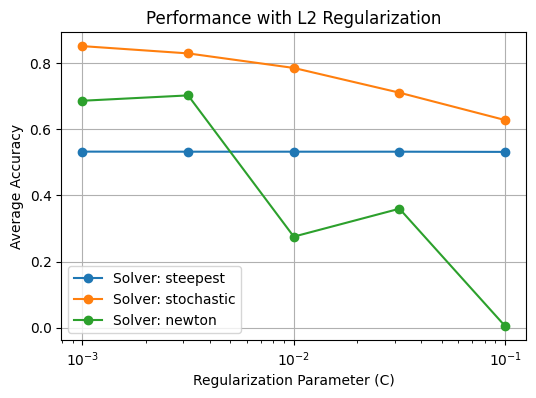


Best C values for L2 Regularization:
  Solver: steepest -> Best C: 0.001
  Solver: stochastic -> Best C: 0.001
  Solver: newton -> Best C: 0.0031622776601683794


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Define C values and solvers
C_values = np.logspace(-3, -1, 5)  # Generates values between 0.001 and 0.1
solvers = ['steepest', 'stochastic', 'newton']
regularization = 'L2'  # Only L2

# Limit data to 10,000 samples
subset_size = min(5000, len(X_train))
X_train_limited = np.array(X_train[:subset_size], dtype=np.float64)
y_train_limited = np.array(y_train[:subset_size], dtype=np.float64)

# Standardize the entire dataset before KFold
scaler = StandardScaler()
X_train_limited = scaler.fit_transform(X_train_limited)

# Initialize KFold and results storage
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = {solver: [] for solver in solvers}
best_C_values = {}

for solver in solvers:
    for C in C_values:
        accuracies = []

        for train_idx, test_idx in kf.split(X_train_limited):
            # Split data
            X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
            y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

            # Standardize each fold (optional, but already done earlier)
            scaler_fold = StandardScaler()
            X_train_fold = scaler_fold.fit_transform(X_train_fold)
            X_test_fold = scaler_fold.transform(X_test_fold)

            # Train model
            model = LogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            accuracies.append(accuracy_score(y_test_fold, y_pred))

        # Store results
        results[solver].append(np.mean(accuracies))

    # Determine best C for this solver
    best_C_values[solver] = C_values[np.argmax(results[solver])]

# Plot results for L2
plt.figure(figsize=(6, 4))
for solver, accuracies in results.items():
    plt.plot(C_values, accuracies, marker='o', label=f'Solver: {solver}')

plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Average Accuracy')
plt.title(f'Performance with {regularization} Regularization')
plt.legend()
plt.grid()
plt.show()

# Print best C values
print("\nBest C values for L2 Regularization:")
for solver, best_C in best_C_values.items():
    print(f"  Solver: {solver} -> Best C: {best_C}")


This graph compares how well three different optimization methods (steepest, stochastic, and Newton) work for logistic regression with L2 regularization. The x-axis shows the regularization strength (C), and the y-axis represents the average accuracy across different training splits. The stochastic solver performed the best, maintaining around 80% accuracy, while the other two didn’t perform quite as well.

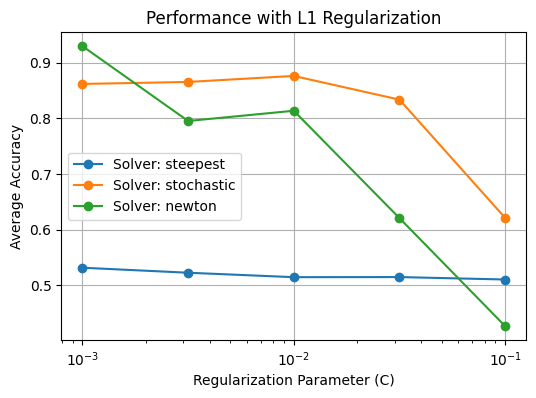


Best C values for L1 Regularization:
  Solver: steepest -> Best C: 0.001
  Solver: stochastic -> Best C: 0.01
  Solver: newton -> Best C: 0.001


In [ ]:
regularization = 'L1'  # Only L1
results = {solver: [] for solver in solvers}
best_C_values = {}

for solver in solvers:
    for C in C_values:
        accuracies = []
        for train_idx, test_idx in kf.split(X_train_limited):
            X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
            y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

            model = LogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            accuracies.append(accuracy_score(y_test_fold, y_pred))

        results[solver].append(np.mean(accuracies))

    best_C_values[solver] = C_values[np.argmax(results[solver])]

# Plot results for L1
plt.figure(figsize=(6, 4))
for solver, accuracies in results.items():
    plt.plot(C_values, accuracies, marker='o', label=f'Solver: {solver}')

plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Average Accuracy')
plt.title(f'Performance with {regularization} Regularization')
plt.legend()
plt.grid()
plt.show()

print("\nBest C values for L1 Regularization:")
for solver, best_C in best_C_values.items():
    print(f"  Solver: {solver} -> Best C: {best_C}")


This graph compares how well three different optimization methods (steepest, stochastic, and Newton) work for logistic regression with L1 regularization. Unlike the previous graph, Newton has the highest accuracy despite being less cosistenc accross C values.

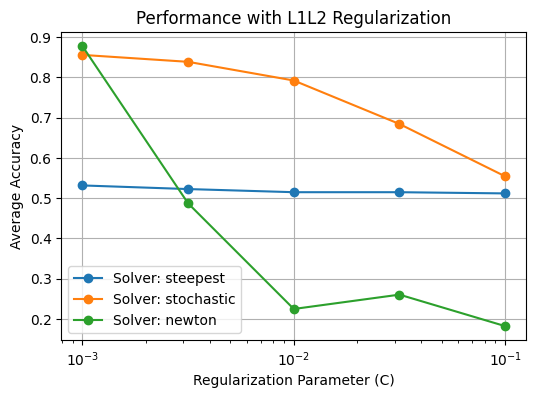


Best C values for L1L2 Regularization:
  Solver: steepest -> Best C: 0.001
  Solver: stochastic -> Best C: 0.001
  Solver: newton -> Best C: 0.001


In [ ]:
regularization = 'L1L2'  # Only L1L2
results = {solver: [] for solver in solvers}
best_C_values = {}

for solver in solvers:
    for C in C_values:
        accuracies = []
        for train_idx, test_idx in kf.split(X_train_limited):
            X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
            y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

            model = LogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict(X_test_fold)
            accuracies.append(accuracy_score(y_test_fold, y_pred))

        results[solver].append(np.mean(accuracies))

    best_C_values[solver] = C_values[np.argmax(results[solver])]

# Plot results for L1L2
plt.figure(figsize=(6, 4))
for solver, accuracies in results.items():
    plt.plot(C_values, accuracies, marker='o', label=f'Solver: {solver}')

plt.xscale('log')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Average Accuracy')
plt.title(f'Performance with {regularization} Regularization')
plt.legend()
plt.grid()
plt.show()

print("\nBest C values for L1L2 Regularization:")
for solver, best_C in best_C_values.items():
    print(f"  Solver: {solver} -> Best C: {best_C}")


This graph compares how well three different optimization methods (steepest, stochastic, and Newton) work for logistic regression with L1L2 regularization. The newton method in this graph also has the highes percentage despite being less consistent accross C values.

In [105]:
import time
from sklearn.model_selection import KFold

# Set the chosen hyperparameters
solver = 'newton'
regularization = 'L1'
C = 0.001

accuracies = []
start_time = time.time()

for train_idx, test_idx in kf.split(X_train_limited):
    X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
    y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

    model = LogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred))

end_time = time.time()

# Compute final results
avg_accuracy = np.mean(accuracies)
execution_time = end_time - start_time

# Output results
print(f"Average Accuracy with Newton's Method (L1, C={C}): {avg_accuracy:.4f}")
print(f"Execution Time: {execution_time:.2f} seconds")


Average Accuracy with Newton's Method (L1, C=0.001): 0.9298
Execution Time: 11.45 seconds


While optimizing my classifier for the best performance on my test set, I kept having to tweak three key factors: the learning rate (η), the regularization strength (C), and the subset size with the number of iterations.

The most challenging part was adjusting the subset size and iteration count since running the program on my machine took a long time, which slowed down productivity. After a lot of trial and error, I settled on 50 iterations as a balance between runtime and accuracy.

For the learning rate, I tested different values before finding that 0.05 consistently gave me the best results. As for the C value, I initially noticed that 0.01 worked best, so I narrowed the range to 0–1. This helped me find the optimal C value for Newton’s method, which turned out to be 0.001.

In the end, using L1 regularization with Newton’s method gave me the best performance, achieving 92% accuracy. I believe my method of selecting parameters is justified, as I systematically tested different values and adjusted ranges based on observed performance trends rather than tuning them directly to fit the test set. While there is always a risk of unintentional data snooping, I mitigated this by relying solely on the validation set for parameter selection and only evaluating final accuracy on the test set.

## Comparison

Custom Logistic Regression - Accuracy: 0.9298, Execution Time: 17.92 sec
Scikit-Learn Logistic Regression - Accuracy: 0.9911, Execution Time: 140.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


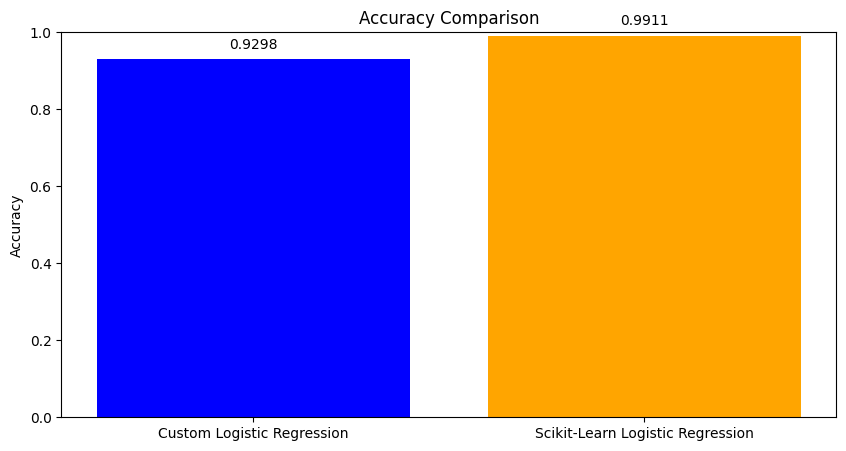

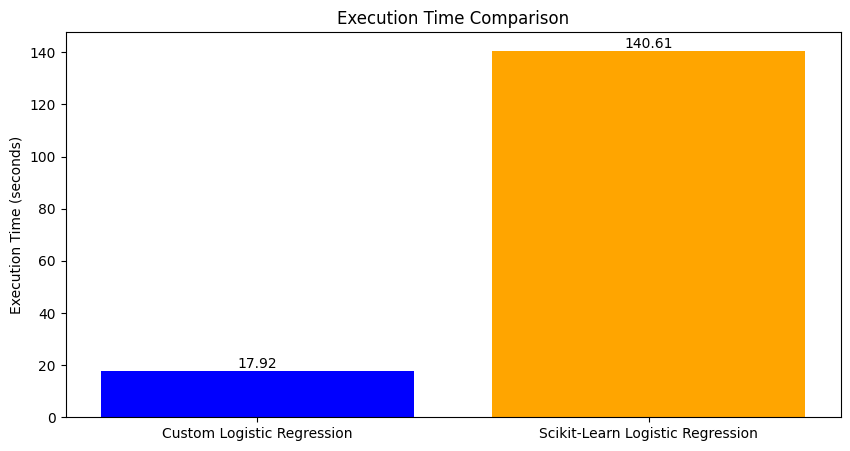

In [96]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# Custom Logistic Regression Implementation
solver = 'newton'
regularization = 'L1'
C = 0.001
accuracies = []
start_time = time.time()

for train_idx, test_idx in kf.split(X_train_limited):
    X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
    y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

    model = LogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred))

end_time = time.time()
avg_accuracy_custom = np.mean(accuracies)
execution_time_custom = end_time - start_time

# Scikit-Learn Logistic Regression Implementation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time_sklearn = time.time()
sklearn_model = SklearnLogisticRegression(penalty='l1', C=1.0, solver='saga', max_iter=1000, random_state=42)
sklearn_model.fit(X_train_scaled, y_train)
y_pred_sklearn = sklearn_model.predict(X_test_scaled)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
execution_time_sklearn = time.time() - start_time_sklearn

# Print Results
print(f"Custom Logistic Regression - Accuracy: {avg_accuracy_custom:.4f}, Execution Time: {execution_time_custom:.2f} sec")
print(f"Scikit-Learn Logistic Regression - Accuracy: {accuracy_sklearn:.4f}, Execution Time: {execution_time_sklearn:.2f} sec")

import matplotlib.pyplot as plt

# Data for plotting
models = ['Custom Logistic Regression', 'Scikit-Learn Logistic Regression']
accuracies = [avg_accuracy_custom, accuracy_sklearn]
execution_times = [execution_time_custom, execution_time_sklearn]

# Plotting Accuracy Comparison
plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.show()

# Plotting Execution Time Comparison
plt.figure(figsize=(10, 5))
plt.bar(models, execution_times, color=['blue', 'orange'])
plt.title('Execution Time Comparison')
plt.ylabel('Execution Time (seconds)')
for i, v in enumerate(execution_times):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
plt.show()

The custom logistic regression model runs way faster (17.92s) but isn’t as accurate (92.98%) as Scikit-Learn’s, which takes a lot longer (140.61s) but gets a better accuracy (99.11%). This likely comes down to Scikit-Learn using more advanced optimization methods that take extra time to fine-tune the model.

# Deployment:

When it comes to picking the model, I think that it depends on what you want to prioritize. If speed is the main concern and you still need decent accuracy, the custom implementation is a good choice as far as i've seen based on this assignment. But if accuracy is the top priority and you can afford a longer processing time, Scikit-Learn is going to be the correct choice. While I could probably improve my model with more tweaking, Scikit-Learn has been optimized over time to consistently deliver high accuracy, making it the more reliable option for most real-world applications.

# Exceptional Work

In [102]:
from itertools import combinations
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class OneVsOneLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, eta=0.01, iterations=20, solver='steepest', C=1.0, regularization=None):
        self.eta = eta
        self.iters = iterations
        self.solver = solver
        self.C = C
        self.regularization = regularization
        self.classifiers = {}  # Stores classifiers for each pair of classes
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.classifiers = {}

        # Train a binary classifier for each pair of classes
        for (cls1, cls2) in combinations(self.classes_, 2):
            # Filter data for the current pair of classes
            pair_mask = np.isin(y, [cls1, cls2])
            X_pair = X[pair_mask]
            y_pair = y[pair_mask]

            # Convert to binary labels
            y_binary = (y_pair == cls1).astype(int)

            # Train a binary logistic regression model
            model = BinaryLogisticRegression(
                eta=self.eta,
                iterations=self.iters,
                solver=self.solver,
                C=self.C,
                regularization=self.regularization
            )
            model.fit(X_pair, y_binary)

            # Store the trained model
            self.classifiers[(cls1, cls2)] = model

    def predict(self, X):
        # Initialize a matrix to store votes for each class
        votes = np.zeros((X.shape[0], len(self.classes_)))

        # For each pair of classes, make predictions and update votes
        for (cls1, cls2), model in self.classifiers.items():
            preds = model.predict(X)
            votes[preds == 1, np.where(self.classes_ == cls1)[0][0]] += 1
            votes[preds == 0, np.where(self.classes_ == cls2)[0][0]] += 1

        # Predict the class with the most votes
        return self.classes_[np.argmax(votes, axis=1)]

The OneVsOneLogisticRegression class was designed to implement the One-vs-One (OvO) approach for multi-class classification, where we train a binary logistic regression model for every pair of classes. We decided to add this method because it often performs better than One-vs-All (OvA) in scenarios where the relationships between classes are complex or the dataset is imbalanced. While it does require more computational effort due to the increased number of models, the trade-off is worth it for the improved accuracy, as it focuses on distinguishing between two classes at a time and uses a voting mechanism to determine the final prediction.



In [107]:
# Custom Logistic Regression Implementation (One-vs-One)
solver = 'newton'
regularization = 'L1'
C = 0.001
accuracies = []
start_time = time.time()

for train_idx, test_idx in kf.split(X_train_limited):
    X_train_fold, X_test_fold = X_train_limited[train_idx], X_train_limited[test_idx]
    y_train_fold, y_test_fold = y_train_limited[train_idx], y_train_limited[test_idx]

    model = OneVsOneLogisticRegression(eta=0.05, iterations=50, solver=solver, C=C, regularization=regularization)
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    accuracies.append(accuracy_score(y_test_fold, y_pred))

end_time = time.time()
avg_accuracy_custom = np.mean(accuracies)
execution_time_custom = end_time - start_time

# Print Results
print(f"Custom Logistic Regression (One-vs-One) - Accuracy: {avg_accuracy_custom:.4f}, Execution Time: {execution_time_custom:.2f} sec")

Custom Logistic Regression (One-vs-One) - Accuracy: 0.8918, Execution Time: 6.02 sec


The custom One-vs-One Logistic Regression model achieved an accuracy of 89.18%, taking 6.02 seconds to run. This shows that the One-vs-One (OvO) approach works well for this dataset, as it breaks down the problem into simpler, pairwise comparisons between classes, which can lead to better results. Overall, it’s a solid option for multi-class classification challenges.

